In [95]:
#!/usr/bin/python3
# coding: -*- utf-8 -*-
# Tokyo

In [123]:
import codecs
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import pandas as pd
import sklearn
import sys
from urllib.request import urlretrieve

In [124]:
def age2int(age):
    x = age.replace('-', '-1').replace('代', '').replace('10歳未満', '0').replace('100歳以上', '100').replace('不明', '-1')
    if len(x) == 0:
        return -1
    return int(x)


In [125]:
def code2int(code):
    if len(code) == 0:
        return -1
    return int(code)


In [126]:
patients_file = "130001_tokyo_covid19_patients.csv"
patients_uri = "https://stopcovid19.metro.tokyo.lg.jp/data/"
if not os.path.exists(patients_file):
    urlretrieve(patients_uri + patients_file, patients_file)

In [134]:
patients = []
with codecs.open(patients_file, encoding="utf-8") as f:
    l = f.readline()
    while l:
        l = f.readline().replace("\r\n", "")
        arr = l.split(',')
        if len(arr) == 16:
            patients.append(
                [
                    code2int(arr[0]), # No
                    code2int(arr[1]), # code
                    arr[2], # state
                    arr[4], # date
                    arr[5], # day of week
                    arr[7], # live in
                    age2int(arr[8]), # age
                    arr[9], # sex
                    arr[15] # discharge
                ]
            )

print("Total: {}".format(len(patients)))
#print(patients[0])

Total: 25113


In [135]:
df = pd.DataFrame(patients, columns=['No', 'Code', 'State', 'Date', 'DoW', 'LiveIn', 'Age', 'Sex', 'Discharge'])

In [136]:
daily_new = df.groupby('Date').size()
print("{}".format(daily_new))
frm_date = daily_new.index[0]
end_date = daily_new.index[-1]

Date
2020-01-24      1
2020-01-25      1
2020-01-30      1
2020-02-13      1
2020-02-14      2
             ... 
2020-09-22     88
2020-09-23     59
2020-09-24    195
2020-09-25    195
2020-09-26    270
Length: 221, dtype: int64


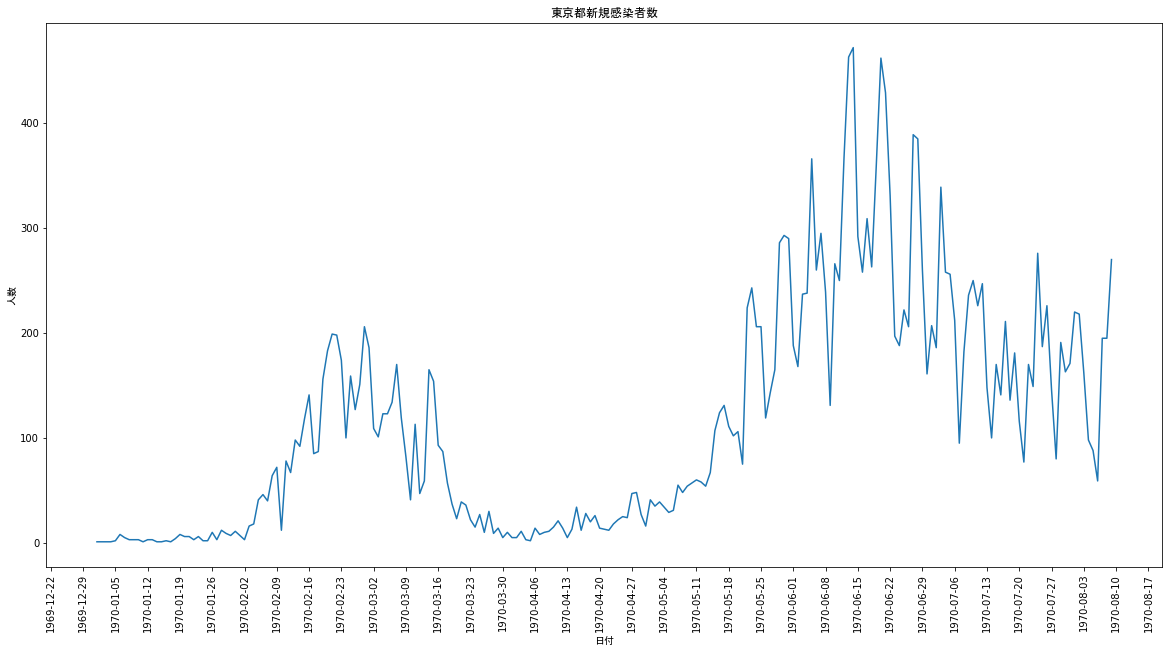

In [139]:
fontname = 'MS Gothic'
fig, ax = plt.subplots(figsize=(20,10))
ax.xaxis.set_major_locator(dates.DayLocator(bymonthday=None, interval=7, tz=None))
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y-%m-%d"))


plt.plot(daily_new.index, daily_new, '-')
plt.title('東京都新規感染者数', fontname=fontname)
plt.xlabel('日付', fontname=fontname)
plt.ylabel('人数', fontname=fontname)
plt.grid(False)
plt.xticks(rotation=90, fontsize=10)
plt.show()